In this notebook, we will discuss what it means to examine a signal from the frequency domain. You should be aware that there is a significant amount of complex mathematics that underlies these transformations, but we will be jumping straight into the practical application of these concepts.

# Important: Run this code cell each time you start a new session!

In [1]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install os
!pip install librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from IPython.display import Audio
import librosa as lr
import librosa.display

ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os


In [2]:
!wget -Ncnp https://physionet.org/files/accelerometry-walk-climb-drive/1.0.0/raw_accelerometry_data/id00b70b13.csv

--2024-06-21 03:37:10--  https://physionet.org/files/accelerometry-walk-climb-drive/1.0.0/raw_accelerometry_data/id00b70b13.csv
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25931775 (25M) [text/plain]
Saving to: ‘id00b70b13.csv’

id00b70b13.csv      100%[===================>]  24.73M   569KB/s    in 46s     

2024-06-21 03:37:57 (551 KB/s) - ‘id00b70b13.csv’ saved [25931775/25931775]



In [3]:
df = pd.read_csv('id00b70b13.csv')

# Filter to only walking activity, which is given a code of 1
df = df[df['activity'] == 1]

# Process the time
df.rename(columns={'time_s': 'Time'}, inplace=True)
df = df[(df['Time']>=700) & (df['Time']<=710)]
df['Time'] = df['Time'] - df['Time'].min()

# Process the accel
df['Accel'] = np.sqrt(df['la_x']**2 + df['la_y']**2 + df['la_z']**2)*9.8

# Keep only crucial columns
keep_cols = ['Time', 'Accel']
df = df[keep_cols]
df.to_csv('walking.csv',index=False)

In [4]:
!wget -Ncnp https://physionet.org/files/sufhsdb/1.0.1/f1.wav

--2024-06-21 03:37:58--  https://physionet.org/files/sufhsdb/1.0.1/f1.wav
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2432684 (2.3M) [text/plain]
Saving to: ‘f1.wav’

f1.wav              100%[===================>]   2.32M   565KB/s    in 4.4s    

2024-06-21 03:38:03 (540 KB/s) - ‘f1.wav’ saved [2432684/2432684]



In [5]:
os.rename('f1.wav', 'heart_sound.wav')

# Fourier Transform

The ***Fourier transform*** is a mathematical technique that transforms a signal from the time domain to the frequency domain, breaking down a signal into a sum of sinusoids (i.e., sine or cosine waves) of different frequencies.

The ***fast Fourier transform (FFT)*** is an efficient algorithm that allows us to apply the Fourier transform on a signal with discrete data points, which will be the case anytime we work with real-world data that is digitally sampled.

There is also an ***inverse Fourier transform*** and an ***inverse fast Fourier transform***, which convert a signal from the frequency domain to the time domain. However, we will skip over these since we will generally be working with data that starts in the time domain.

Both `numpy` and `scipy` have implementations of the FFT algorithm, both of which are called `fft()`. `scipy`'s implementation builds upon `numpy`'s functionality with a few extra features, so we will use that one.

Let's write some code to do the following:
1. Plot a signal in the time domain
2. Calculate the FFT
3. Plot the result in the frequency domain

In [6]:
from numpy.fft import fftfreq
from scipy.fftpack import fft
def show_fft(x, y, fs=1000, time_ylim=None, fft_xlim_max=None):
    """
    Shows the time-domain signal and the corresponding FFT
    x: the timestamps of the signal as a Numpy array
    y: the values of the signal as a Numpy array
    fs: the sampling rate of our signal
    time_ylim: the boundaries of the y-axis for the time-domain plot
    fft_xlim_max: the right boundary for the x-axis of the FFT plot,
    indicating the highest frequency we care to view
    """
    # Compute the FFT
    fft_mag = np.abs(fft(y))
    freqs = fftfreq(len(y), 1/fs)

    # Keep the components associated with positive frequencies
    pos_freq_idxs = freqs >= 0
    freqs = freqs[pos_freq_idxs]
    fft_mag = fft_mag[pos_freq_idxs]

    # Show the signal in the time domain
    plt.figure(figsize=(12, 3))
    plt.subplot(1, 2, 1)
    plt.plot(x, y)
    plt.xlabel('Time (s)')
    plt.ylabel('Value')
    if time_ylim:
        plt.ylim(time_ylim[0], time_ylim[1])
    plt.title('Time Domain')

    # Show the signal in the frequency domain
    plt.subplot(1, 2, 2)
    plt.stem(freqs, fft_mag, markerfmt=" ", basefmt="-")
    plt.xlabel('Freq (Hz)')
    plt.ylabel('FFT Amplitude |X(freq)|')
    plt.xlim(-0.1, fft_xlim_max if fft_xlim_max else freqs.max())
    plt.title('Frequency Domain')
    plt.show()

A couple of notes before we see this function in action:
* Right after we calculate the FFT of the signal, you probably notice that we have some extra lines of code to only keep values at indeces associated with positive frequencies. This is because the Fourier transform has the notion of negative frequency in order to make the complex mathematics work out. Nevertheless, we typically only care about the parts associated with positive frequencies, in large part because many FFTs are symmetric across positive and negative frequencies.
* Our function accepts a third argument: the sampling rate of our signal. For now, we will assume it is a very large value to ensure that we accurately represent our signal, and we will use this parameter in a couple of places to properly view our FFT. We will get into why the sampling rate is important for digital Fourier transforms later.

To illustrate how powerful an FFT can be, let's write a helper function to create a signal composed of one or many sinusoids with varying frequencies and amplitudes:

In [7]:
def generate_sinusoid(freqs, amps, fs=1000):
    """
    Computes a linear combination of sinusoids with various frequencies and amplitudes
    freqs: a list of frequencies
    amps: a list of amplitudes
    fs: the sampling rate of our signal
    """
    x = np.arange(0, 5, 1.0/fs)
    y = 0
    for freq, amp in zip(freqs, amps):
        y += amp*np.sin(2*np.pi*freq*x)
    return x, y

Play around with the examples below to deduce what the FFT is able to show us.

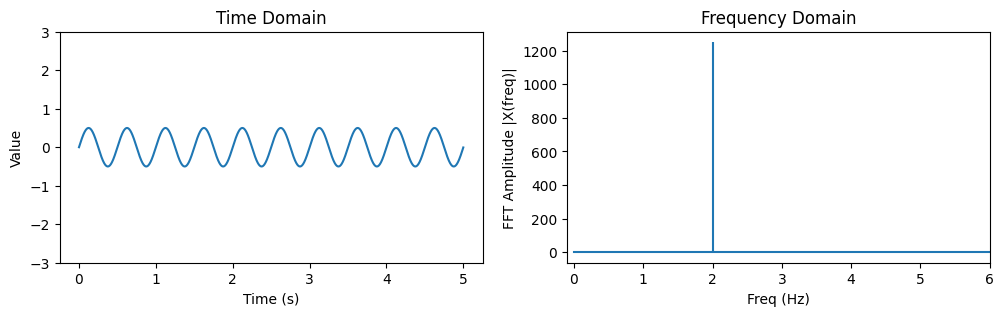

In [8]:
freq = 2 #@param {type:"slider", min:1, max:5, step:1}
amp = 0.5 #@param {type:"slider", min:0.5, max:1.5, step:0.5}
x, y = generate_sinusoid([freq], [amp])
show_fft(x, y, time_ylim=[-3, 3], fft_xlim_max=6)

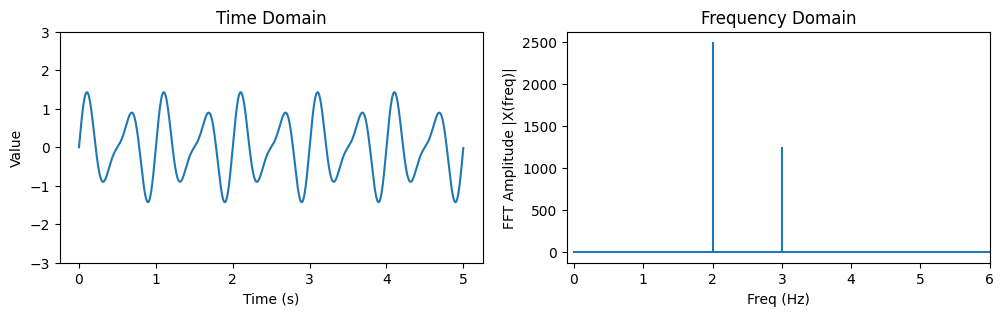

In [9]:
freq1 = 2 #@param {type:"slider", min:1, max:5, step:1}
freq2 = 3 #@param {type:"slider", min:1, max:5, step:1}
amp1 = 1 #@param {type:"slider", min:0.5, max:1.5, step:0.5}
amp2 = 0.5 #@param {type:"slider", min:0.5, max:1.5, step:0.5}
x, y = generate_sinusoid([freq1, freq2], [amp1, amp2])
show_fft(x, y, time_ylim=[-3, 3], fft_xlim_max=6)

Here are some observations to be gathered from these examples:
* **Location of the spikes:** When a sinusoidal signal is fed into the FFT algorithm, the resulting frequency spectrum will exhibit a peak at the frequency of the sinusoid. For example, a sinusoid at 3 Hz will have a spike at 3 Hz in its FFT.
* **Relative height of the spikes:** The height of the peak represents the strength of each frequency component. We don't really need to concern ourselves with the absolute magnitude of the spike, but rather the relative magnitude of all the spikes in the FFT. For example, if a signal has components at 2 Hz and at 3 Hz but the latter has twice the amplitude of the former, then the spike at 3 Hz in the FFT will be twice as large.


Although most real-world signals are not going to look nearly as clean as any of the periodic signals we've examined up until this point, it turns out that almost all signals can be broken down into a combination of sinusoids. Let's revisit our real-world signals from earlier in the lecture.

# Example 1: Step Counting with Motion Data

Let's generate the FFT of our walking motion data:

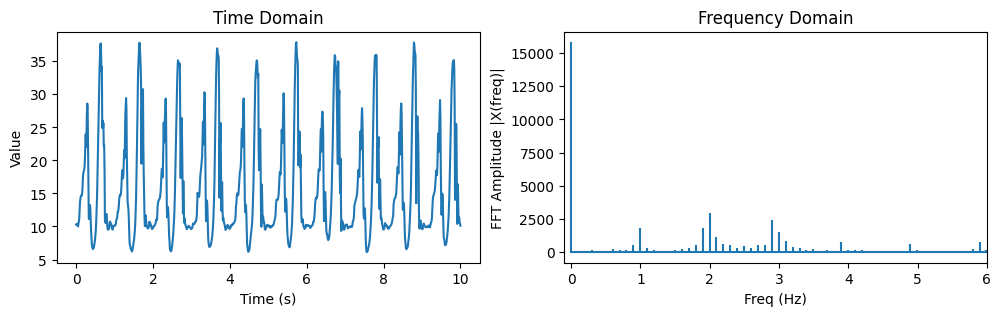

In [10]:
df = pd.read_csv('walking.csv')
x = df['Time'].values
y = df['Accel'].values
show_fft(x, y, fs=100, fft_xlim_max=6)

There is a significant spike in our FFT at 0 Hz. A sinusoid with a frequency of 0 Hz is essentially a flat line ($\sin(0) = 0$), so where is this flat line in our signal?

Notice that the our time-domain signal is not centered at 0 m/s$^2$, but rather around 20 or 25 m/s$^2$. This offset is achieved in the frequency domain by having a frequency component at 0 Hz. Depending on the kind of data you are analyzing, you might want to include or exclude this offset.

To get rid of the offset, we can simply subtract the mean of the overall signal so that it is centered around 0 m/s$^2$. Let's see what happens when we do that:

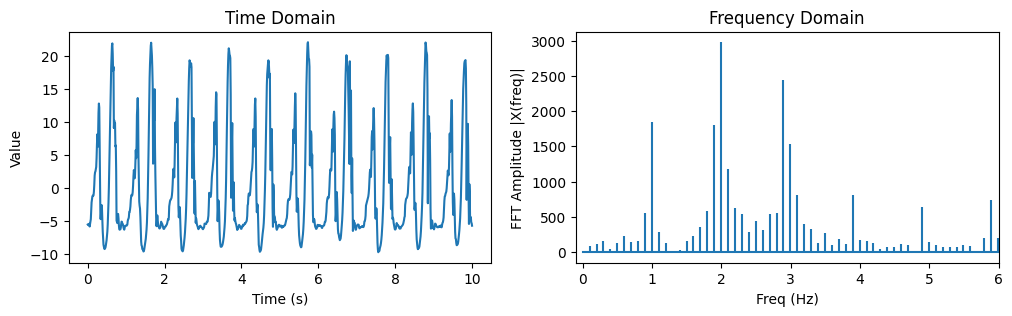

In [11]:
df = pd.read_csv('walking.csv')
x = df['Time'].values
y = df['Accel'].values
y -= y.mean()
show_fft(x, y, fs=100, fft_xlim_max=6)

Now let's talk about the rest of what we see in our FFT:
* **Most dominant spike:** The most dominant spike in our FFT is at 2 Hz. If you look at our signal, you can see that we have roughly two peaks per second. This shows that just by calling the `fft()` function, we were able to quickly identify that the person was taking roughly two steps per second!
* **Frequency content near the most dominant spike:** The spike at 2 Hz isn't on its own. Rather, there is some frequency content at 1.7–1.9 Hz and 2.1–2.3 Hz. This is due to a variety of factors like signal noise, limited frequency resolution, and the fact that the person may not be walking at *exactly* 2 Hz.
* **Second-most dominant spike:** We also have a relatively large spike at 1 Hz. This could be because the motion sensor was on a single ankle, so one footstep is more prominent than the other. That foot takes one step per second, so we see a corresponding peak there.
* **Other spikes:** We don't just have spikes at 1 Hz and 2 Hz. We also have spikes at every multiple of 1 Hz, and the height of these spikes decreases with higher multiples. This is due to ***harmonic resonance***, which is the result of various physical phenomena beyond the scope of this lecture. Mathematically, the intuition of why harmonics happen is because sinusoids with integer-multiples frequencies have similar shape characteristics, namely some of the places where they intersect with the line $y=0$. The plot below illustrates this point.

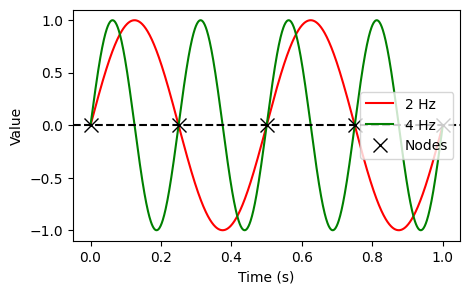

In [12]:
x = np.linspace(0, 1, 1000)
y2 = np.sin(2*np.pi*2*x)
y4 = np.sin(2*np.pi*4*x)

plt.figure(figsize=(5,3))
plt.plot(x, y2, 'r-', label='2 Hz')
plt.plot(x, y4, 'g-', label='4 Hz')
plt.axhline(y=0, color='k', linestyle='--')
plt.plot([0, 0.25, 0.5, 0.75, 1], [0, 0, 0, 0, 0], 'kx', markersize=10, label='Nodes')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Value')
plt.show()

# Example 2: Heart Sound Audio

Let's generate the FFT of our heart sound audio:

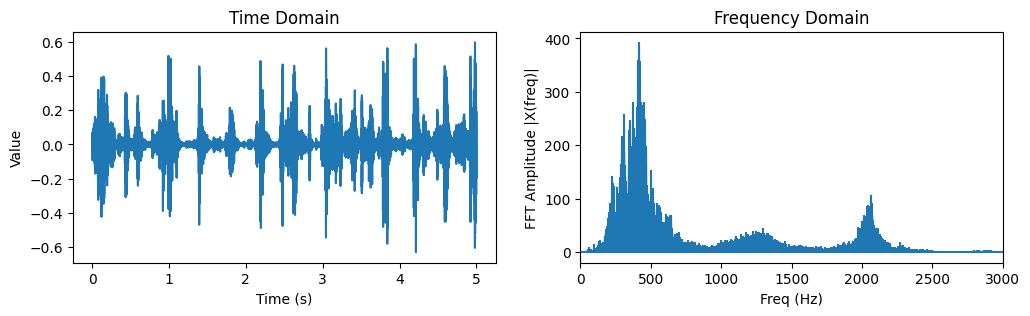

In [13]:
y, fs = librosa.load('heart_sound.wav', sr=16000, mono=True,
                     offset=25, duration=5)
time = np.arange(0, len(y))/fs
show_fft(time, y, fs=fs, fft_xlim_max=3000)

As we can see, the most significant frequency in this signal is somewhere around 480 Hz, which corresponds to a relatively low-pitch tone. However, this FFT is much more messy than any we have seen up until this point, and there are a couple of reasons for this:
* **Sampling rate**: The data is recorded at a much higher frequency, so we can accurately characterize a wide variety of frequencies.
* **Changes in the signal properties**: This audio recording is not a single tone. Rather, it is a complex combination of all sorts of tones. If we were to compare this audio recording to a song, each sound is a chord is composed of multiple tones, and different chords are played over time with breaks in between.

While this FFT gives us a rough idea of the overall characteristics of the sound, what we really need is a technique that will allow us to compute an FFT over a shorter sliding window so that we can accurately represent how the audio changes over time. We will talk about such a technique in a few moments, but first...

# Nyquist–Shannon Sampling Theorem

Recall that we had to keep track for the sampling rate of our signal in order to properly view the results of the FFT. Increasing the sampling rate increases the fidelity with which we can digitally capture the signal over time. This enables us to identify higher frequency content (i.e., quicker oscillations) in the signal. Conversely, if the signal oscillates at a quicker rate than we are digitally sampling, then we will not have the measurements necessary to record that information.

The **Nyquist-Shannon sampling theorem** (sometimes simply called **Nyquist's theorem**) relates sampling rate to the highest frequency we can capture in our signal. It states that in order to accurately reconstruct a continuous-time signal from its discrete samples, the sampling rate must be at least twice the highest frequency present in the signal.

Play around with the sliders below to see what happens in the following situations:
* `sampling rate` < 2*`signal_freq`
* `sampling rate` = 2*`signal_freq`
* `sampling rate` > 2*`signal_freq`
* `sampling rate` >> 2*`signal_freq`

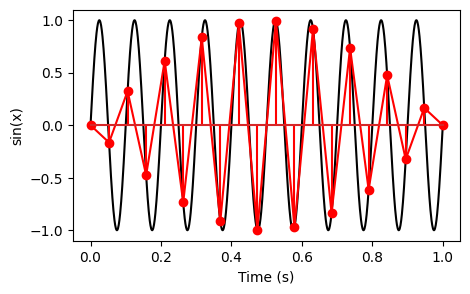

In [14]:
signal_freq = 10 #@param {type:"slider", min:10, max:40, step:10}
sampling_rate = 20 #@param {type:"slider", min:10, max:40, step:10}

# Calculate the "real signal"
x = np.linspace(0, 1, 1000)
y = np.sin(2*np.pi*signal_freq*x)

# Calculate the "sampled signal"
x_sampled = np.linspace(0, 1, sampling_rate)
y_sampled = np.sin(2*np.pi*signal_freq*x_sampled)

# Plot both of them
plt.figure(figsize=(5, 3))
plt.plot(x, y, 'k-')
plt.plot(x_sampled, y_sampled, 'r-')
plt.stem(x_sampled, y_sampled, 'r')
plt.xlabel('Time (s)')
plt.ylabel('sin(x)')
plt.show()

Here's what happens in each situation:
* `sampling rate` < 2*`signal_freq`: We sample data too slowly and are unable to accurately capture the quick oscillations in the signal.
* `sampling rate` = 2*`signal_freq`: We record at least one sample for each peak and trough in the black signal. The magnitude of the signal is not accurate, but we can at least accurately capture the signal's frequency content.
* `sampling rate` > 2*`signal_freq`: The higher the sampling rate, the more our sampled signal in red looks like our original signal in black.

There are a few key takeaways from Nyquist's theorem for the sake of this course:
1. Assuming the rate at which you are sampling data is fixed, you will only be able to capture frequency information up to half of that rate.
2. If you know in advance that the signal you are trying to record exhibits a range of frequencies, then you should make sure that you are recording data at a rate at least twice as fast as the highest frequency. For example, most microphones go as high as 44.1 kHz since human hearing can detect sounds as high as 18 kHz.
3. Many functions that help with frequency-domain analysis require that you specify the sampling rate of your signal in order to know which frequencies can be reasonably captured from your data.